In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Shape of dataset: (62645, 24)
Nombre de clusters détectés : 699
Nombre de points de bruit : 10380

DBSCAN (scikit-learn) métriques :
Silhouette Score        : -0.0636
Davies-Bouldin Index    : 1.2511
Calinski-Harabasz Index: 219.5338


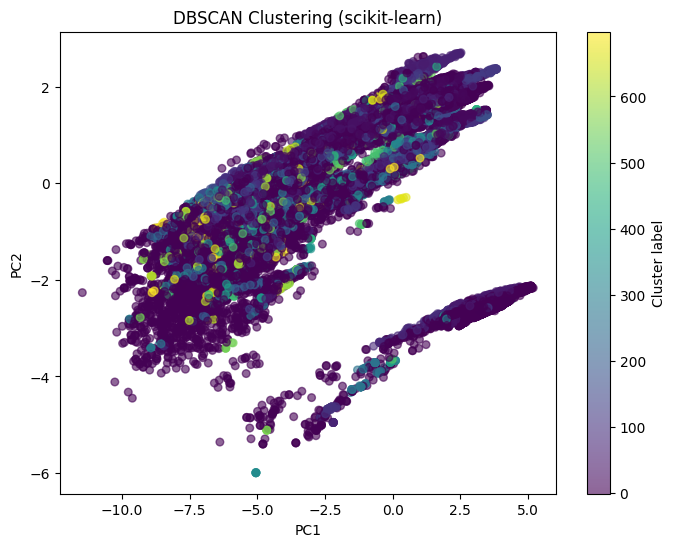

In [ ]:
# ==========================================
# 1️⃣ Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# ==========================================
# 2️⃣ Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
df = pd.read_csv(f"{data_dir}/X_scaled.csv")
X = df.values  # Dataset déjà normalisé

print(f"Shape of dataset: {X.shape}")

# ==========================================
# 3️⃣ DBSCAN avec scikit-learn
# ==========================================
eps = 0.5
min_samples = 5

dbscan = DBSCAN(
    eps=eps,
    min_samples=min_samples,
    metric='euclidean'
)

labels_dbscan = dbscan.fit_predict(X)

# ==========================================
# 4️⃣ Résultats
# ==========================================
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = np.sum(labels_dbscan == -1)

print(f"Nombre de clusters détectés : {n_clusters}")
print(f"Nombre de points de bruit : {n_noise}")

# ==========================================
# 5️⃣ Métriques d’évaluation
# ==========================================
if n_clusters > 1:
    silhouette_db = silhouette_score(X, labels_dbscan)
    db_index = davies_bouldin_score(X, labels_dbscan)
    ch_index = calinski_harabasz_score(X, labels_dbscan)

    print("\nDBSCAN (scikit-learn) métriques :")
    print(f"Silhouette Score        : {silhouette_db:.4f}")
    print(f"Davies-Bouldin Index    : {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")
else:
    print("Impossible de calculer les métriques : moins de 2 clusters.")

# ==========================================
# 6️⃣ Visualisation (PCA)
# ==========================================
if X.shape[1] > 2:
    X_vis = PCA(n_components=2).fit_transform(X)
else:
    X_vis = X

plt.figure(figsize=(8, 6))
plt.scatter(
    X_vis[:, 0],
    X_vis[:, 1],
    c=labels_dbscan,
    cmap='viridis',
    s=30,
    alpha=0.6
)
plt.title("DBSCAN Clustering (scikit-learn)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster label")
plt.show()


In [ ]:
!pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1959507 sha256=a5f0966344c58a2238f61c95f3a88b89dff4efcdb4cdc67c879563669c098fb2
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [ ]:
# ==========================================
# 1️⃣ Imports
# ==========================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids  # Maintenant disponible

# ==========================================
# 2️⃣ Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
df = pd.read_csv(f"{data_dir}/X_scaled.csv")
X = df.values  # Dataset déjà normalisé
print(f"Shape of dataset: {X.shape}")

# ==========================================
# 3️⃣ Implémentation CLARANS
# ==========================================
def clarans(X, k, numlocal=5, maxneighbor=50, random_state=None):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    best_medoids = None
    best_cost = np.inf

    def total_cost(medoids):
        dist = cdist(X, X[medoids], metric='euclidean')
        return np.sum(np.min(dist, axis=1))

    for _ in range(numlocal):
        medoids = np.random.choice(n_samples, k, replace=False)
        neighbor_examined = 0

        while neighbor_examined < maxneighbor:
            m_idx = np.random.choice(k)
            non_medoids = [i for i in range(n_samples) if i not in medoids]
            o_idx = np.random.choice(non_medoids)

            new_medoids = medoids.copy()
            new_medoids[m_idx] = o_idx
            cost_new = total_cost(new_medoids)
            cost_current = total_cost(medoids)

            if cost_new < cost_current:
                medoids = new_medoids
                neighbor_examined = 0
            else:
                neighbor_examined += 1

        cost_final = total_cost(medoids)
        if cost_final < best_cost:
            best_cost = cost_final
            best_medoids = medoids

    distances = cdist(X, X[best_medoids], metric='euclidean')
    labels = np.argmin(distances, axis=1)

    return best_medoids, labels

# ==========================================
# 4️⃣ Appliquer CLARANS
# ==========================================
k = 4
medoids_clarans, labels_clarans = clarans(X, k=k, numlocal=5, maxneighbor=50, random_state=42)

print("CLARANS results:")
print(f"Medoids indices: {medoids_clarans}")
for i in range(k):
    print(f"Cluster {i}: {(labels_clarans == i).sum()} points")

# ==========================================
# 5️⃣ CLARANS métriques
# ==========================================
silhouette_c = silhouette_score(X, labels_clarans)
db_c = davies_bouldin_score(X, labels_clarans)
ch_c = calinski_harabasz_score(X, labels_clarans)

print("\nCLARANS métriques :")
print(f"Silhouette Score: {silhouette_c:.4f}")
print(f"Davies-Bouldin Index: {db_c:.4f}")
print(f"Calinski-Harabasz Index: {ch_c:.4f}")

# ==========================================
# 6️⃣ Appliquer KMedoids de scikit-learn-extra
# ==========================================
kmedoids = KMedoids(n_clusters=k, metric='euclidean', random_state=42)
labels_kmedoids = kmedoids.fit_predict(X)
medoids_kmedoids = kmedoids.medoid_indices_

print("\nKMedoids results (scikit-learn-extra):")
print(f"Medoids indices: {medoids_kmedoids}")
for i in range(k):
    print(f"Cluster {i}: {(labels_kmedoids == i).sum()} points")

# ==========================================
# 7️⃣ KMedoids métriques
# ==========================================
silhouette_k = silhouette_score(X, labels_kmedoids)
db_k = davies_bouldin_score(X, labels_kmedoids)
ch_k = calinski_harabasz_score(X, labels_kmedoids)

print("\nKMedoids métriques :")
print(f"Silhouette Score: {silhouette_k:.4f}")
print(f"Davies-Bouldin Index: {db_k:.4f}")
print(f"Calinski-Harabasz Index: {ch_k:.4f}")

# ==========================================
# 8️⃣ Visualisation comparée
# ==========================================
if X.shape[1] > 2:
    X_vis = PCA(n_components=2).fit_transform(X)
else:
    X_vis = X

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# CLARANS
axes[0].scatter(X_vis[:, 0], X_vis[:, 1], c=labels_clarans, s=30, cmap='viridis', alpha=0.6)
axes[0].scatter(X_vis[medoids_clarans, 0], X_vis[medoids_clarans, 1], c='red', s=200, marker='X', label='Medoids')
axes[0].set_title("CLARANS Clustering")
axes[0].legend()

# KMedoids
axes[1].scatter(X_vis[:, 0], X_vis[:, 1], c=labels_kmedoids, s=30, cmap='viridis', alpha=0.6)
axes[1].scatter(X_vis[medoids_kmedoids, 0], X_vis[medoids_kmedoids, 1], c='red', s=200, marker='X', label='Medoids')
axes[1].set_title("KMedoids (scikit-learn-extra)")
axes[1].legend()

plt.show()



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

Shape of dataset: (62645, 24)
Medoids indices: [ 3596 49670 56268   646]
Nombre de points par cluster:
Cluster 0: 14505 points
Cluster 1: 8660 points
Cluster 2: 19823 points
Cluster 3: 19657 points

Métriques de clustering :
Silhouette Score: 0.3498 (plus proche de 1 = mieux)
Davies-Bouldin Index: 1.1092 (plus petit = mieux)
Calinski-Harabasz Index: 28213.1042 (plus grand = mieux)


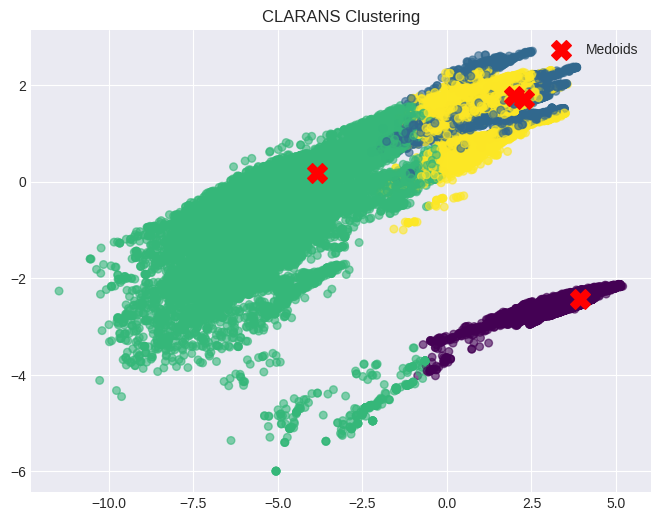

In [ ]:
# ==========================================
# 1️⃣ Imports
# ==========================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

# ==========================================
# 2️⃣ Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
df = pd.read_csv(f"{data_dir}/X_scaled.csv")
X = df.values  # Dataset déjà normalisé
print(f"Shape of dataset: {X.shape}")

# ==========================================
# 3️⃣ Implémentation CLARANS
# ==========================================
def clarans(X, k, numlocal=5, maxneighbor=50, random_state=None):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    best_medoids = None
    best_cost = np.inf

    # Fonction de coût : somme des distances aux medoids les plus proches
    def total_cost(medoids):
        dist = cdist(X, X[medoids], metric='euclidean')
        return np.sum(np.min(dist, axis=1))

    for _ in range(numlocal):
        # Initialiser k medoids aléatoires
        medoids = np.random.choice(n_samples, k, replace=False)
        neighbor_examined = 0

        while neighbor_examined < maxneighbor:
            # Choisir un medoid aléatoire à remplacer
            m_idx = np.random.choice(k)
            non_medoids = [i for i in range(n_samples) if i not in medoids]
            o_idx = np.random.choice(non_medoids)

            # Swap et calcul du coût
            new_medoids = medoids.copy()
            new_medoids[m_idx] = o_idx
            cost_new = total_cost(new_medoids)
            cost_current = total_cost(medoids)

            if cost_new < cost_current:
                medoids = new_medoids
                neighbor_examined = 0
            else:
                neighbor_examined += 1

        cost_final = total_cost(medoids)
        if cost_final < best_cost:
            best_cost = cost_final
            best_medoids = medoids

    # Assignation des clusters
    distances = cdist(X, X[best_medoids], metric='euclidean')
    labels = np.argmin(distances, axis=1)

    return best_medoids, labels

# ==========================================
# 4️⃣ Appliquer CLARANS
# ==========================================
k = 4  # Choisir le nombre de clusters désiré
medoids, labels = clarans(X, k=k, numlocal=5, maxneighbor=50, random_state=42)

print(f"Medoids indices: {medoids}")
print("Nombre de points par cluster:")
for i in range(k):
    print(f"Cluster {i}: {(labels == i).sum()} points")

# ==========================================
# 5️⃣ Calcul des métriques de clustering
# ==========================================
silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)

print("\nMétriques de clustering :")
print(f"Silhouette Score: {silhouette:.4f} (plus proche de 1 = mieux)")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f} (plus petit = mieux)")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f} (plus grand = mieux)")

# ==========================================
# 6️⃣ Visualisation (2D via PCA si nécessaire)
# ==========================================
if X.shape[1] > 2:
    X_vis = PCA(n_components=2).fit_transform(X)
else:
    X_vis = X

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, s=30, cmap='viridis', alpha=0.6)
plt.scatter(X_vis[medoids, 0], X_vis[medoids, 1], c='red', s=200, marker='X', label='Medoids')
plt.title("CLARANS Clustering")
plt.legend()
plt.show()


In [ ]:
# ==========================================
# 1️⃣ Imports
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# ==========================================
# 2️⃣ Charger les données
# ==========================================
data_dir = "/content/drive/MyDrive/processed_unsupervised"
df = pd.read_csv(f"{data_dir}/X_scaled.csv")
X = df.values  # Dataset déjà normalisé
print(f"Shape of dataset: {X.shape}")

# ==========================================
# 3️⃣ Implémentation DBSCAN from scratch
# ==========================================
def dbscan(X, eps=0.5, min_samples=5):
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # -1 = bruit
    cluster_id = 0

    def region_query(point_idx):
        # Retourne les indices des points dans le voisinage de eps
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        neighbors = np.where(distances <= eps)[0]
        return neighbors

    def expand_cluster(point_idx, neighbors):
        nonlocal cluster_id
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            n_idx = neighbors[i]
            if labels[n_idx] == -1:
                labels[n_idx] = cluster_id  # Marquer comme cluster
            elif labels[n_idx] == -1 or labels[n_idx] == -1:
                labels[n_idx] = cluster_id
            if labels[n_idx] == -1:
                labels[n_idx] = cluster_id
            if labels[n_idx] == -1 or labels[n_idx] == cluster_id:
                # Vérifier si ce point est un core point
                n_neighbors = region_query(n_idx)
                if len(n_neighbors) >= min_samples:
                    neighbors = np.concatenate((neighbors, n_neighbors))
            i += 1

    for idx in range(n_samples):
        if labels[idx] != -1:
            continue
        neighbors = region_query(idx)
        if len(neighbors) < min_samples:
            labels[idx] = -1  # Bruit
        else:
            expand_cluster(idx, neighbors)
            cluster_id += 1

    return labels

# ==========================================
# 4️⃣ Appliquer DBSCAN
# ==========================================
eps = 0.5          # Distance maximale pour le voisinage
min_samples = 5    # Nombre minimum de voisins pour core point

labels_dbscan = dbscan(X, eps=eps, min_samples=min_samples)
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Nombre de clusters détectés: {n_clusters}")
print(f"Nombre de points de bruit: {(labels_dbscan == -1).sum()}")

# ==========================================
# 5️⃣ Métriques
# ==========================================
# Les métriques ne fonctionnent pas si tout est bruit ou un seul cluster
if n_clusters > 1:
    silhouette_db = silhouette_score(X, labels_dbscan)
    db_index = davies_bouldin_score(X, labels_dbscan)
    ch_index = calinski_harabasz_score(X, labels_dbscan)
    print("\nDBSCAN métriques :")
    print(f"Silhouette Score: {silhouette_db:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")
else:
    print("Impossible de calculer les métriques : DBSCAN a trouvé moins de 2 clusters.")

# ==========================================
# 6️⃣ Visualisation
# ==========================================
if X.shape[1] > 2:
    X_vis = PCA(n_components=2).fit_transform(X)
else:
    X_vis = X

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=labels_dbscan, cmap='viridis', s=30, alpha=0.6)
plt.title("DBSCAN Clustering (from scratch)")
plt.show()


Shape of dataset: (62645, 24)


CHARGEMENT DU DATASET COMPLET POUR CLARANS
📊 Dimensions du dataset : (62645, 24)
📈 Nombre d'échantillons : 62,645
🎯 Nombre de features : 24
💾 Taille mémoire : 0.01 GB

PCA POUR VISUALISATION

📊 PCA POUR VISUALISATION
   Échantillon: 5000 points
   Variance expliquée PC1: 48.4%
   Variance expliquée PC2: 12.8%
   Variance totale: 61.3%

EXÉCUTION DE CLARANS FROM SCRATCH

🚀 DÉBUT CLARANS SUR 62,645 POINTS
   k=3, num_local=3, max_neighbor=50
------------------------------------------------------------

  🔍 RECHERCHE LOCALE 1/3
    Coût initial: 250,644.65
    Medoids initiaux: [14187   849 43061]
    Optimisation locale PAM...
    ✅ Nouveau meilleur coût: 201,930.43

  🔍 RECHERCHE LOCALE 2/3
    Coût initial: 272,360.25
    Medoids initiaux: [31133 60549 19234]
    Optimisation locale PAM...
    ✅ Nouveau meilleur coût: 199,498.31

  🔍 RECHERCHE LOCALE 3/3
    Coût initial: 224,218.31
    Medoids initiaux: [49240 10354 47440]
    Optimisation locale PAM...
    ✅ Nouveau meilleur coût: 19

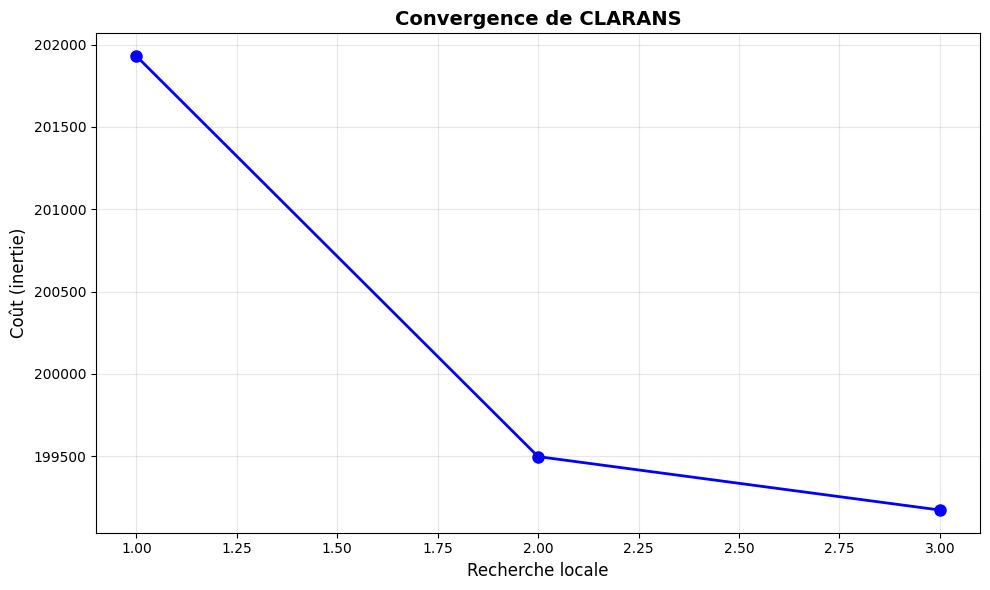


⚙️  PARAMÈTRES UTILISÉS:
   Nombre de clusters (k): 3
   Nombre de recherches locales: 3
   Nombre maximum de voisins: 50
   Nombre total d'itérations: 16

VISUALISATION DES RÉSULTATS


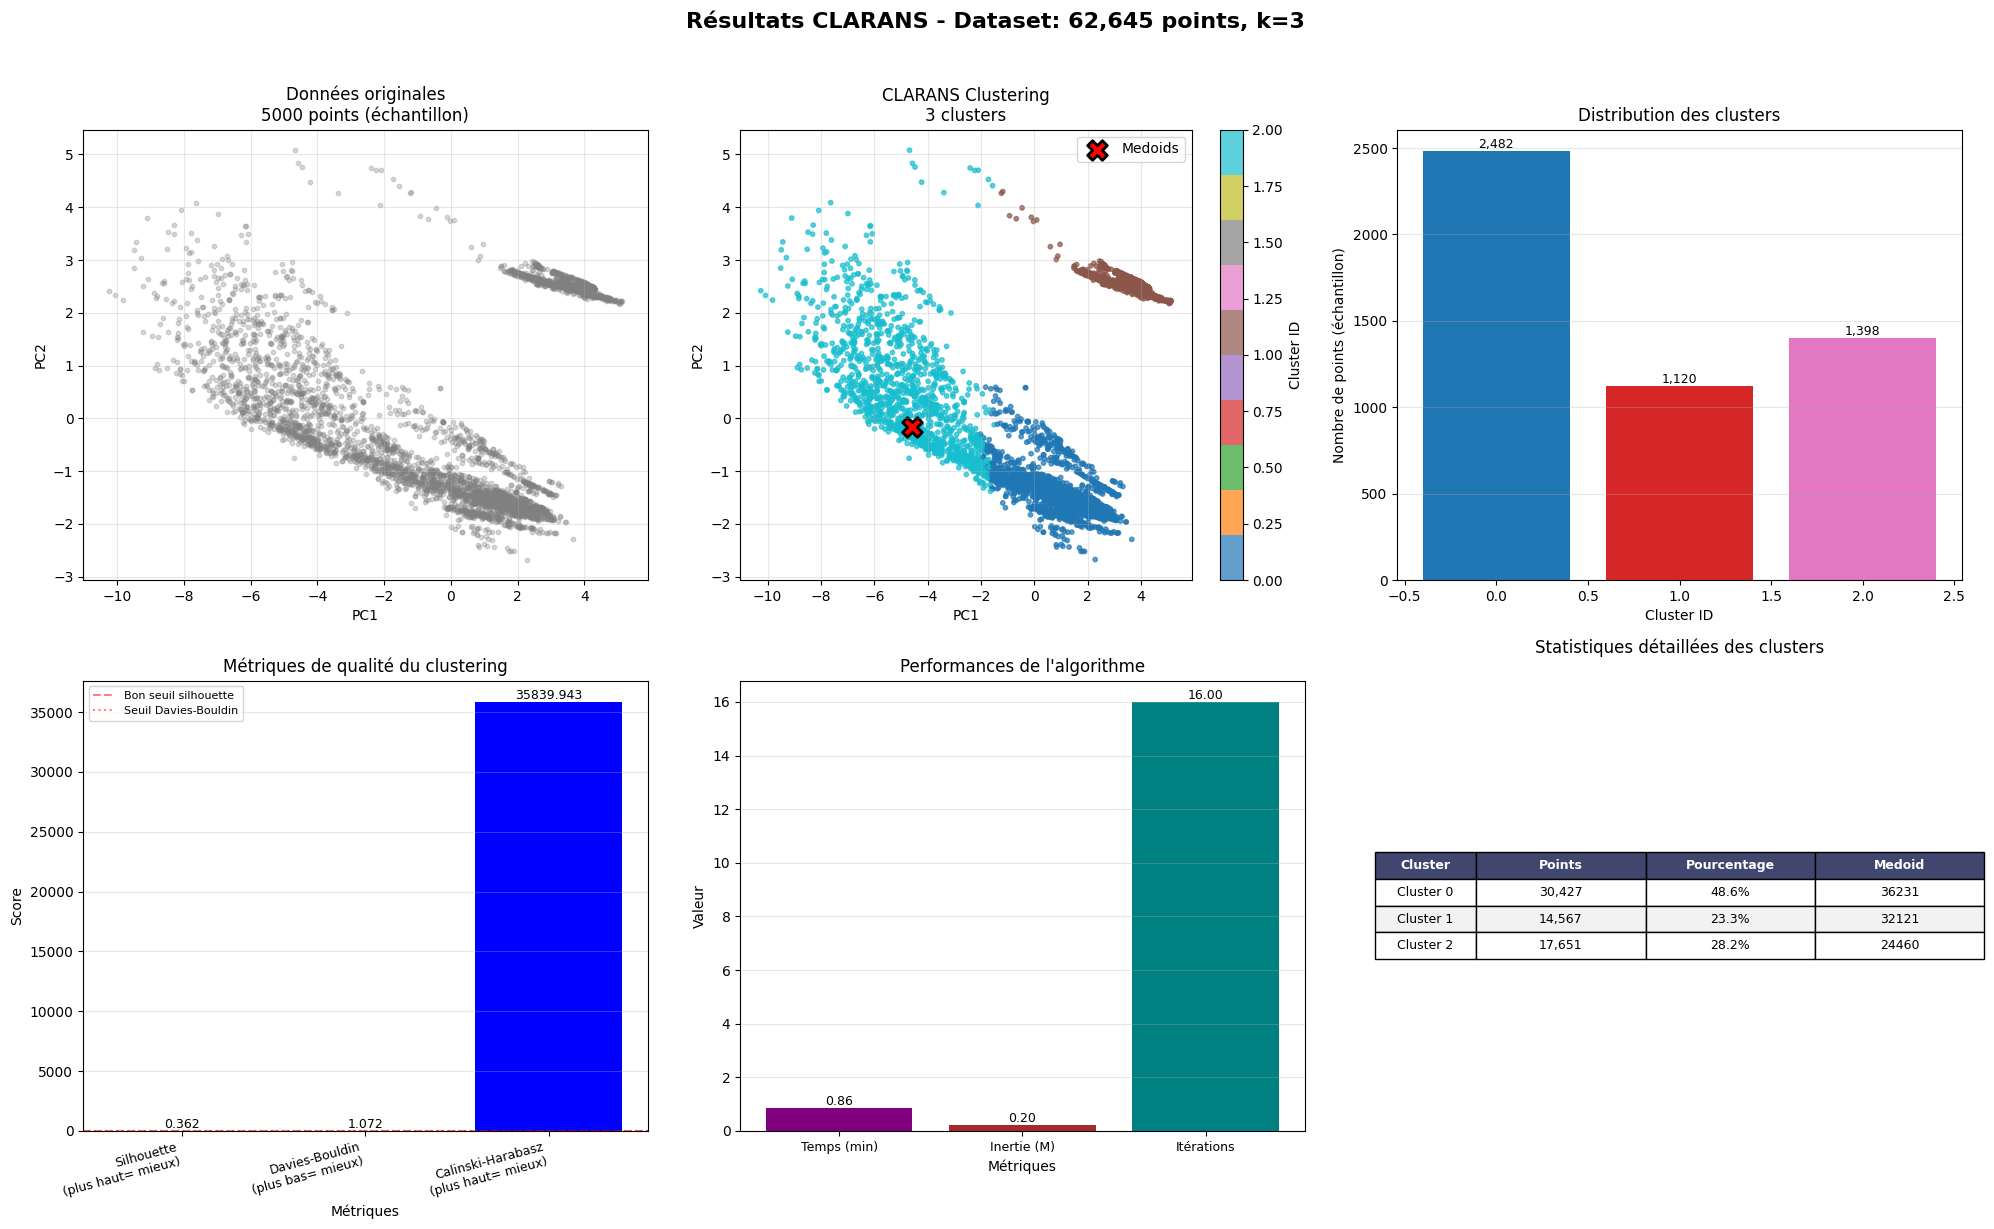


ANALYSE DE ROBUSTESSE

🔬 ANALYSE DE ROBUSTESSE (3 runs avec initialisations différentes)
------------------------------------------------------------

  Run 1/3:
    Inertie: 31,610.85
    Silhouette: 0.3547
    Temps: 3.72s
    Medoids: [2651 1078 8777]

  Run 2/3:
    Inertie: 31,585.19
    Silhouette: 0.3558
    Temps: 3.37s
    Medoids: [6711 8362  423]

  Run 3/3:
    Inertie: 31,585.35
    Silhouette: 0.3555
    Temps: 5.68s
    Medoids: [8362  439 1423]

  📊 STATISTIQUES DE ROBUSTESSE:
    Inertie moyenne: 31,593.80 ± 12.06
    Silhouette moyenne: 0.3553 ± 0.0005
    Temps moyen: 4.26s (0.1 min)
    CV Inertie: 0.0%
    CV Silhouette: 0.1%


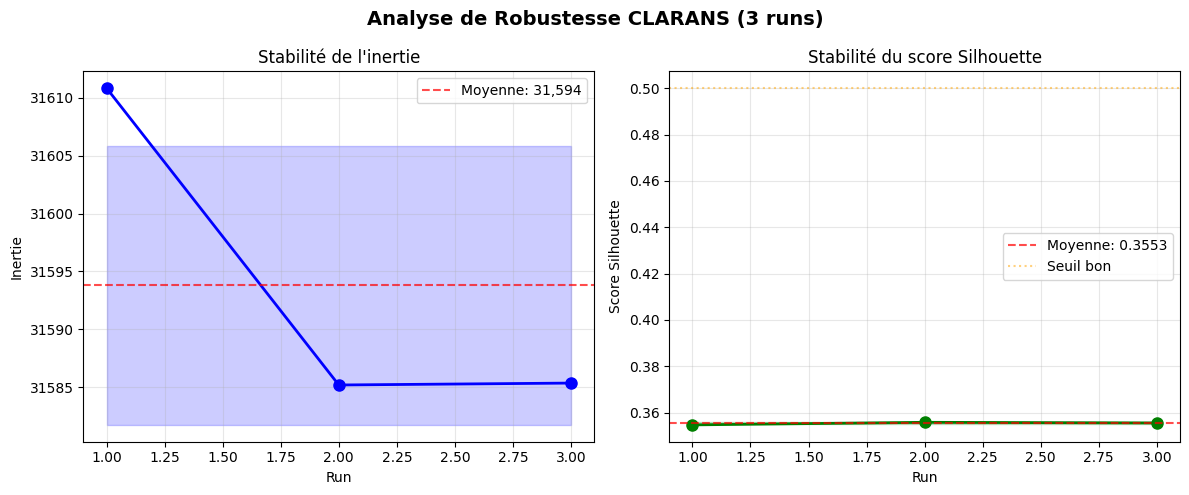


SAUVEGARDE DES RÉSULTATS
✅ Labels CLARANS sauvegardés: /content/drive/MyDrive/processed_unsupervised/clarans_labels_complete.csv
   Taille: 62,645 lignes
✅ Métriques CLARANS sauvegardées: /content/drive/MyDrive/processed_unsupervised/clarans_metrics_complete.csv
✅ Medoids CLARANS sauvegardés: /content/drive/MyDrive/processed_unsupervised/clarans_medoids_complete.csv
✅ Historique des coûts sauvegardé: /content/drive/MyDrive/processed_unsupervised/clarans_cost_history.csv
✅ Données de visualisation sauvegardées: /content/drive/MyDrive/processed_unsupervised/clarans_visualization_data.csv
✅ Statistiques des clusters sauvegardées: /content/drive/MyDrive/processed_unsupervised/clarans_cluster_statistics.csv

RAPPORT FINAL - CLARANS FROM SCRATCH

🎯 RÉSUMÉ DE L'EXPÉRIMENTATION:
   • Dataset: 62,645 points × 24 features
   • Algorithme: CLARANS (Clustering Large Applications based on RANdomized Search)
   • Paramètres: k=3, num_local=3, max_neighbor=50

⚡ PERFORMANCE:
   • Temps d'exécution: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
import time
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================================

print("="*80)
print("CHARGEMENT DU DATASET COMPLET POUR CLARANS")
print("="*80)

# Charger les données
data_dir = "/content/drive/MyDrive/processed_unsupervised"
df = pd.read_csv(f"{data_dir}/X_scaled.csv")
X = df.values

print(f"📊 Dimensions du dataset : {X.shape}")
print(f"📈 Nombre d'échantillons : {X.shape[0]:,}")
print(f"🎯 Nombre de features : {X.shape[1]}")
print(f"💾 Taille mémoire : {X.nbytes / (1024**3):.2f} GB")

# Utiliser TOUT le dataset
X_full = X
n_samples, n_features = X_full.shape

# ============================================================================
# 2. IMPLÉMENTATION CLARANS FROM SCRATCH COMPLÈTE
# ============================================================================

class CLARANSFromScratch:
    """
    Implémentation complète de CLARANS (Clustering Large Applications based on RANdomized Search)
    Sans échantillonnage - Utilise tout le dataset
    """

    def __init__(self, n_clusters=3, num_local=3, max_neighbor=50,
                 random_state=42, metric='euclidean', verbose=True):
        """
        Initialisation de CLARANS

        Paramètres:
        - n_clusters: Nombre de clusters (k)
        - num_local: Nombre d'optima locaux à explorer
        - max_neighbor: Nombre maximum de voisins à explorer par optimum local
        - random_state: Seed pour la reproductibilité
        - metric: Métrique de distance ('euclidean', 'manhattan', etc.)
        - verbose: Affichage des informations de progression
        """
        self.n_clusters = n_clusters
        self.num_local = num_local
        self.max_neighbor = max_neighbor
        self.random_state = random_state
        self.metric = metric
        self.verbose = verbose

        np.random.seed(random_state)
        random.seed(random_state)

        self.medoids = None
        self.labels = None
        self.inertia = None
        self.centroids = None
        self.cost_history = []
        self.execution_time = None
        self.n_iterations = 0

    def _compute_cost(self, X, medoids):
        """
        Calcule le coût total (somme des distances aux medoids les plus proches)
        """
        # Calcul des distances de chaque point à chaque medoid
        distances = cdist(X, X[medoids], metric=self.metric)

        # Coût = somme des distances minimales
        cost = np.sum(np.min(distances, axis=1))

        return cost

    def _find_best_neighbor(self, X, current_medoids, current_cost):
        """
        Trouve le meilleur voisin en testant des échanges
        Optimisé pour grands datasets
        """
        n_samples = X.shape[0]
        best_medoids = current_medoids.copy()
        best_cost = current_cost
        improved = False

        # Points non-medoids
        all_indices = set(range(n_samples))
        medoid_set = set(current_medoids)
        non_medoids = list(all_indices - medoid_set)

        # Pour accélérer, on teste un nombre limité de candidats
        n_candidates = min(100, len(non_medoids))
        candidates = np.random.choice(non_medoids, n_candidates, replace=False)

        # Pré-calculer les distances aux medoids actuels
        current_distances = cdist(X, X[current_medoids], metric=self.metric)

        for i in range(self.n_clusters):
            current_medoid = current_medoids[i]

            for candidate in candidates:
                if candidate == current_medoid:
                    continue

                # Créer nouveaux medoids
                new_medoids = current_medoids.copy()
                new_medoids[i] = candidate

                # Calculer nouveau coût
                new_cost = self._compute_cost(X, new_medoids)

                # Mettre à jour si meilleur
                if new_cost < best_cost:
                    best_medoids = new_medoids
                    best_cost = new_cost
                    improved = True

        return best_medoids, best_cost, improved

    def _pam_local_optimization(self, X, medoids):
        """
        Optimisation locale PAM (Partitioning Around Medoids)
        """
        current_medoids = medoids.copy()
        current_cost = self._compute_cost(X, current_medoids)

        max_iter = min(20, self.max_neighbor)
        iteration = 0

        while iteration < max_iter:
            # Trouver le meilleur voisin
            new_medoids, new_cost, improved = self._find_best_neighbor(
                X, current_medoids, current_cost
            )

            # Si pas d'amélioration, arrêter
            if not improved:
                break

            # Mettre à jour
            current_medoids = new_medoids
            current_cost = new_cost
            iteration += 1

        return current_medoids, current_cost

    def fit(self, X):
        """
        Entraînement de l'algorithme CLARANS sur dataset complet
        """
        start_time = time.time()
        n_samples = X.shape[0]

        if self.verbose:
            print(f"\n🚀 DÉBUT CLARANS SUR {n_samples:,} POINTS")
            print(f"   k={self.n_clusters}, num_local={self.num_local}, max_neighbor={self.max_neighbor}")
            print("-" * 60)

        # Meilleure solution globale
        global_best_medoids = None
        global_best_cost = float('inf')

        # Exploration de plusieurs optima locaux
        for local_idx in range(self.num_local):
            if self.verbose:
                print(f"\n  🔍 RECHERCHE LOCALE {local_idx + 1}/{self.num_local}")

            # 1. Initialisation aléatoire des medoids
            current_medoids = np.random.choice(n_samples, self.n_clusters, replace=False)
            current_cost = self._compute_cost(X, current_medoids)

            if self.verbose:
                print(f"    Coût initial: {current_cost:,.2f}")
                print(f"    Medoids initiaux: {current_medoids}")

            # 2. Recherche locale aléatoire (CLARANS core)
            for neighbor_idx in range(self.max_neighbor):
                # Générer un voisin aléatoire
                medoid_to_replace = np.random.randint(0, self.n_clusters)

                # Liste des points non-medoids
                all_indices = set(range(n_samples))
                medoid_set = set(current_medoids)
                non_medoids = list(all_indices - medoid_set)

                if non_medoids:
                    new_medoid = np.random.choice(non_medoids)

                    # Créer nouveau set de medoids
                    new_medoids = current_medoids.copy()
                    new_medoids[medoid_to_replace] = new_medoid

                    # Calculer nouveau coût
                    new_cost = self._compute_cost(X, new_medoids)

                    # Accepter si meilleur
                    if new_cost < current_cost:
                        current_medoids = new_medoids
                        current_cost = new_cost
                        self.n_iterations += 1

            # 3. Optimisation locale avec PAM
            if self.verbose:
                print(f"    Optimisation locale PAM...")
            current_medoids, current_cost = self._pam_local_optimization(X, current_medoids)

            # 4. Mettre à jour le meilleur global
            if current_cost < global_best_cost:
                global_best_medoids = current_medoids
                global_best_cost = current_cost
                self.cost_history.append(global_best_cost)

                if self.verbose:
                    print(f"    ✅ Nouveau meilleur coût: {global_best_cost:,.2f}")

        # 5. Assignation finale des clusters
        if self.verbose:
            print(f"\n  🎯 ASSIGNATION DES CLUSTERS...")
        self.medoids = global_best_medoids
        self.centroids = X[global_best_medoids]

        # Assignation par batchs pour économiser la mémoire
        batch_size = 5000
        n_batches = (n_samples + batch_size - 1) // batch_size
        self.labels = np.zeros(n_samples, dtype=int)

        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, n_samples)

            batch_data = X[start_idx:end_idx]
            distances = cdist(batch_data, self.centroids, metric=self.metric)
            self.labels[start_idx:end_idx] = np.argmin(distances, axis=1)

            if self.verbose and (batch_idx + 1) % 10 == 0:
                progress = (batch_idx + 1) / n_batches * 100
                print(f"    Progression: {progress:.1f}%", end='\r')

        if self.verbose:
            print(f"    Progression: 100.0% - Terminé!")

        # 6. Calcul final des métriques
        self.inertia = global_best_cost
        self.execution_time = time.time() - start_time

        if self.verbose:
            print(f"\n✅ CLARANS TERMINÉ !")
            print(f"   Temps: {self.execution_time:.2f}s ({self.execution_time/60:.1f} min)")
            print(f"   Inertie finale: {self.inertia:,.2f}")
            print(f"   Medoids finaux: {self.medoids}")
            print(f"   Historique des coûts: {[f'{c:,.0f}' for c in self.cost_history]}")

        return self

    def fit_predict(self, X):
        """Entraînement et prédiction"""
        self.fit(X)
        return self.labels

    def predict(self, X_new):
        """Prédiction pour de nouvelles données"""
        distances = cdist(X_new, self.centroids, metric=self.metric)
        return np.argmin(distances, axis=1)

    def get_cluster_statistics(self):
        """Retourne les statistiques des clusters"""
        if self.labels is None:
            return None

        cluster_ids = np.unique(self.labels)
        stats = {}

        for cluster_id in cluster_ids:
            cluster_points = np.sum(self.labels == cluster_id)
            stats[f'cluster_{cluster_id}'] = {
                'size': cluster_points,
                'percentage': cluster_points / len(self.labels) * 100,
                'medoid_index': self.medoids[cluster_id] if cluster_id < len(self.medoids) else None
            }

        return stats

# ============================================================================
# 3. FONCTIONS D'ÉVALUATION POUR CLARANS
# ============================================================================

def evaluate_clarans_clustering(X, labels, medoids, execution_time, cost_history):
    """
    Évaluation complète du clustering CLARANS
    """
    print(f"\n📊 ÉVALUATION DES RÉSULTATS CLARANS")
    print("-" * 50)

    results = {
        'n_clusters': len(np.unique(labels)),
        'n_samples': len(X),
        'execution_time': execution_time,
        'inertia': None,
        'medoids': medoids,
        'cost_history': cost_history
    }

    # Statistiques des clusters
    cluster_counts = np.bincount(labels)
    results['cluster_sizes'] = cluster_counts.tolist()
    results['avg_cluster_size'] = np.mean(cluster_counts)
    results['std_cluster_size'] = np.std(cluster_counts)
    results['min_cluster_size'] = np.min(cluster_counts)
    results['max_cluster_size'] = np.max(cluster_counts)
    results['cluster_distribution'] = (cluster_counts / len(labels) * 100).tolist()

    # Calcul de l'inertie
    centroids = X[medoids]
    distances = cdist(X, centroids, 'euclidean')
    results['inertia'] = np.sum(np.min(distances, axis=1))

    # Métriques de qualité
    if len(np.unique(labels)) >= 2:
        try:
            results['silhouette'] = silhouette_score(X, labels)
        except:
            results['silhouette'] = 0

        try:
            results['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        except:
            results['calinski_harabasz'] = 0

        try:
            results['davies_bouldin'] = davies_bouldin_score(X, labels)
        except:
            results['davies_bouldin'] = float('inf')
    else:
        results['silhouette'] = 0
        results['calinski_harabasz'] = 0
        results['davies_bouldin'] = float('inf')

    # Affichage des résultats
    print(f"   Nombre de clusters: {results['n_clusters']}")
    print(f"   Temps d'exécution: {results['execution_time']/60:.2f} minutes")
    print(f"   Inertie (coût total): {results['inertia']:,.2f}")
    print(f"   Score Silhouette: {results['silhouette']:.4f}")
    print(f"   Score Davies-Bouldin: {results['davies_bouldin']:.4f}")
    print(f"   Score Calinski-Harabasz: {results['calinski_harabasz']:,.0f}")

    print(f"\n   📈 DISTRIBUTION DES CLUSTERS:")
    for i, (size, percentage) in enumerate(zip(results['cluster_sizes'], results['cluster_distribution'])):
        print(f"      Cluster {i}: {size:,} points ({percentage:.1f}%) - Medoid: {medoids[i]}")

    return results

# ============================================================================
# 4. PCA POUR VISUALISATION
# ============================================================================

def pca_for_visualization(X, n_components=2, sample_size=5000):
    """
    PCA sur échantillon pour visualisation
    """
    if X.shape[0] > sample_size:
        np.random.seed(42)
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X
        indices = np.arange(X.shape[0])

    # PCA standard
    X_centered = X_sample - np.mean(X_sample, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    components = eigenvectors[:, :n_components]
    X_pca = np.dot(X_centered, components)

    # Variance expliquée
    total_variance = np.sum(eigenvalues)
    explained_variance = eigenvalues[sorted_indices[:n_components]] / total_variance

    print(f"\n📊 PCA POUR VISUALISATION")
    print(f"   Échantillon: {X_sample.shape[0]} points")
    print(f"   Variance expliquée PC1: {explained_variance[0]*100:.1f}%")
    print(f"   Variance expliquée PC2: {explained_variance[1]*100:.1f}%")
    print(f"   Variance totale: {np.sum(explained_variance)*100:.1f}%")

    return X_pca, indices, X_sample

print("\n" + "="*80)
print("PCA POUR VISUALISATION")
print("="*80)

X_pca, pca_indices, X_vis_sample = pca_for_visualization(X_full, n_components=2, sample_size=5000)

# ============================================================================
# 5. EXÉCUTION DE CLARANS
# ============================================================================

print("\n" + "="*80)
print("EXÉCUTION DE CLARANS FROM SCRATCH")
print("="*80)

# Paramètres de CLARANS
n_clusters = 3
num_local = 3
max_neighbor = 50

# Création et entraînement du modèle
clarans = CLARANSFromScratch(
    n_clusters=n_clusters,
    num_local=num_local,
    max_neighbor=max_neighbor,
    random_state=42,
    verbose=True
)

# Entraînement sur dataset complet
labels_clarans = clarans.fit_predict(X_full)

# Évaluation des résultats
results = evaluate_clarans_clustering(
    X_full,
    labels_clarans,
    clarans.medoids,
    clarans.execution_time,
    clarans.cost_history
)

# ============================================================================
# 6. ANALYSE DE CONVERGENCE ET OPTIMISATION
# ============================================================================

print("\n" + "="*80)
print("ANALYSE DE CONVERGENCE")
print("="*80)

# Analyse de la convergence
if len(clarans.cost_history) > 0:
    print(f"\n📈 ÉVOLUTION DU COÛT:")
    for i, cost in enumerate(clarans.cost_history):
        print(f"   Recherche locale {i+1}: {cost:,.2f}")

    # Amélioration relative
    if len(clarans.cost_history) > 1:
        improvement = (clarans.cost_history[0] - clarans.cost_history[-1]) / clarans.cost_history[0] * 100
        print(f"   Amélioration totale: {improvement:.1f}%")

    # Visualisation de la convergence
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(clarans.cost_history) + 1), clarans.cost_history, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Recherche locale', fontsize=12)
    plt.ylabel('Coût (inertie)', fontsize=12)
    plt.title('Convergence de CLARANS', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Analyse des paramètres
print(f"\n⚙️  PARAMÈTRES UTILISÉS:")
print(f"   Nombre de clusters (k): {n_clusters}")
print(f"   Nombre de recherches locales: {num_local}")
print(f"   Nombre maximum de voisins: {max_neighbor}")
print(f"   Nombre total d'itérations: {clarans.n_iterations}")

# ============================================================================
# 7. VISUALISATION DES RÉSULTATS
# ============================================================================

print("\n" + "="*80)
print("VISUALISATION DES RÉSULTATS")
print("="*80)

def plot_clarans_results(X_pca, labels, medoids, pca_indices, results, clarans_model):
    """Visualisation des résultats de CLARANS"""
    # Extraire les labels pour l'échantillon PCA
    labels_vis = labels[pca_indices]

    # Créer une figure avec plusieurs sous-graphiques
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Données originales
    axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c='gray', alpha=0.3, s=10)
    axes[0, 0].set_title(f'Données originales\n{len(X_pca)} points (échantillon)', fontsize=12)
    axes[0, 0].set_xlabel('PC1', fontsize=10)
    axes[0, 0].set_ylabel('PC2', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Résultats CLARANS
    scatter = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1],
                                 c=labels_vis, cmap='tab10', s=10, alpha=0.7)
    axes[0, 1].set_title(f'CLARANS Clustering\n{len(np.unique(labels_vis))} clusters', fontsize=12)
    axes[0, 1].set_xlabel('PC1', fontsize=10)
    axes[0, 1].set_ylabel('PC2', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 1], label='Cluster ID')

    # Marquer les medoids si visibles dans l'échantillon
    medoids_in_sample = [m for m in medoids if m in pca_indices]
    if medoids_in_sample:
        medoid_positions = []
        for m in medoids_in_sample:
            idx_in_sample = np.where(pca_indices == m)[0][0]
            medoid_positions.append(X_pca[idx_in_sample])

        medoid_positions = np.array(medoid_positions)
        axes[0, 1].scatter(medoid_positions[:, 0], medoid_positions[:, 1],
                          c='red', s=200, marker='X', label='Medoids', edgecolors='black', linewidth=2)
        axes[0, 1].legend()

    # 3. Distribution des clusters
    cluster_counts = np.bincount(labels_vis)
    cluster_ids = np.arange(len(cluster_counts))

    bars = axes[0, 2].bar(cluster_ids, cluster_counts, color=plt.cm.tab10(cluster_ids/len(cluster_counts)))
    axes[0, 2].set_xlabel('Cluster ID', fontsize=10)
    axes[0, 2].set_ylabel('Nombre de points (échantillon)', fontsize=10)
    axes[0, 2].set_title('Distribution des clusters', fontsize=12)
    axes[0, 2].grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:,}', ha='center', va='bottom', fontsize=9)

    # 4. Métriques de qualité
    metrics = ['silhouette', 'davies_bouldin', 'calinski_harabasz']
    metric_names = ['Silhouette\n(plus haut= mieux)', 'Davies-Bouldin\n(plus bas= mieux)', 'Calinski-Harabasz\n(plus haut= mieux)']
    metric_values = [results.get(m, 0) for m in metrics]

    x = np.arange(len(metrics))
    colors = ['green', 'orange', 'blue']

    bars = axes[1, 0].bar(x, metric_values, color=colors)
    axes[1, 0].set_xlabel('Métriques', fontsize=10)
    axes[1, 0].set_ylabel('Score', fontsize=10)
    axes[1, 0].set_title('Métriques de qualité du clustering', fontsize=12)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metric_names, rotation=15, ha='right', fontsize=9)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Ajouter des lignes de référence
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Bon seuil silhouette')
    axes[1, 0].axhline(y=1.0, color='red', linestyle=':', alpha=0.5, label='Seuil Davies-Bouldin')
    axes[1, 0].legend(fontsize=8)

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # 5. Performances
    perf_metrics = ['execution_time', 'inertia', 'n_iterations']
    perf_names = ['Temps (min)', 'Inertie (M)', 'Itérations']

    perf_values = [
        results['execution_time']/60,
        results['inertia']/1e6,
        clarans_model.n_iterations
    ]

    x = np.arange(len(perf_metrics))
    colors = ['purple', 'brown', 'teal']

    bars = axes[1, 1].bar(x, perf_values, color=colors)
    axes[1, 1].set_xlabel('Métriques', fontsize=10)
    axes[1, 1].set_ylabel('Valeur', fontsize=10)
    axes[1, 1].set_title('Performances de l\'algorithme', fontsize=12)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(perf_names, fontsize=9)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    # 6. Statistiques détaillées des clusters
    axes[1, 2].axis('tight')
    axes[1, 2].axis('off')

    # Créer un tableau avec les statistiques
    cluster_stats = []
    for i, (size, percentage) in enumerate(zip(results['cluster_sizes'], results['cluster_distribution'])):
        cluster_stats.append([
            f'Cluster {i}',
            f'{size:,}',
            f'{percentage:.1f}%',
            f'{medoids[i]}'
        ])

    # Tableau récapitulatif
    table_data = [['Cluster', 'Points', 'Pourcentage', 'Medoid']] + cluster_stats

    table = axes[1, 2].table(
        cellText=table_data,
        cellLoc='center',
        loc='center',
        colWidths=[0.15, 0.25, 0.25, 0.25]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Style du tableau
    for i in range(len(table_data)):
        for j in range(len(table_data[0])):
            if i == 0:  # En-tête
                table[(i, j)].set_facecolor('#40466e')
                table[(i, j)].set_text_props(weight='bold', color='white')
            elif i % 2 == 0:  # Lignes paires
                table[(i, j)].set_facecolor('#f2f2f2')

    axes[1, 2].set_title('Statistiques détaillées des clusters', fontsize=12, pad=20)

    plt.suptitle(f'Résultats CLARANS - Dataset: {X_full.shape[0]:,} points, k={n_clusters}',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Générer les visualisations
plot_clarans_results(X_pca, labels_clarans, clarans.medoids, pca_indices, results, clarans)

# ============================================================================
# 8. ANALYSE DE ROBUSTESSE
# ============================================================================

print("\n" + "="*80)
print("ANALYSE DE ROBUSTESSE")
print("="*80)

def analyze_robustness(X, n_runs=3, n_clusters=3):
    """
    Analyse la robustesse de CLARANS avec différentes initialisations
    """
    print(f"\n🔬 ANALYSE DE ROBUSTESSE ({n_runs} runs avec initialisations différentes)")
    print("-" * 60)

    inertias = []
    silhouettes = []
    execution_times = []
    all_medoids = []

    for run in range(n_runs):
        print(f"\n  Run {run + 1}/{n_runs}:")

        clarans_run = CLARANSFromScratch(
            n_clusters=n_clusters,
            num_local=2,  # Réduit pour accélérer
            max_neighbor=30,
            random_state=run * 100,  # Différentes initialisations
            verbose=False
        )

        start_time = time.time()
        labels_run = clarans_run.fit_predict(X)
        run_time = time.time() - start_time

        # Calcul des métriques
        inertia = clarans_run.inertia
        silhouette = silhouette_score(X, labels_run) if len(np.unique(labels_run)) >= 2 else 0

        inertias.append(inertia)
        silhouettes.append(silhouette)
        execution_times.append(run_time)
        all_medoids.append(clarans_run.medoids)

        print(f"    Inertie: {inertia:,.2f}")
        print(f"    Silhouette: {silhouette:.4f}")
        print(f"    Temps: {run_time:.2f}s")
        print(f"    Medoids: {clarans_run.medoids}")

    # Calcul des statistiques
    inertia_mean = np.mean(inertias)
    inertia_std = np.std(inertias)
    silhouette_mean = np.mean(silhouettes)
    silhouette_std = np.std(silhouettes)
    time_mean = np.mean(execution_times)

    print(f"\n  📊 STATISTIQUES DE ROBUSTESSE:")
    print(f"    Inertie moyenne: {inertia_mean:,.2f} ± {inertia_std:.2f}")
    print(f"    Silhouette moyenne: {silhouette_mean:.4f} ± {silhouette_std:.4f}")
    print(f"    Temps moyen: {time_mean:.2f}s ({time_mean/60:.1f} min)")
    print(f"    CV Inertie: {inertia_std/inertia_mean*100:.1f}%")
    print(f"    CV Silhouette: {silhouette_std/max(silhouette_mean, 0.001)*100:.1f}%")

    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Inertie
    axes[0].plot(range(1, n_runs + 1), inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].axhline(y=inertia_mean, color='r', linestyle='--', alpha=0.7, label=f'Moyenne: {inertia_mean:,.0f}')
    axes[0].fill_between(range(1, n_runs + 1),
                         inertia_mean - inertia_std,
                         inertia_mean + inertia_std,
                         alpha=0.2, color='blue')
    axes[0].set_xlabel('Run', fontsize=10)
    axes[0].set_ylabel('Inertie', fontsize=10)
    axes[0].set_title('Stabilité de l\'inertie', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Silhouette
    axes[1].plot(range(1, n_runs + 1), silhouettes, 'go-', linewidth=2, markersize=8)
    axes[1].axhline(y=silhouette_mean, color='r', linestyle='--', alpha=0.7, label=f'Moyenne: {silhouette_mean:.4f}')
    axes[1].fill_between(range(1, n_runs + 1),
                         silhouette_mean - silhouette_std,
                         silhouette_mean + silhouette_std,
                         alpha=0.2, color='green')
    axes[1].axhline(y=0.5, color='orange', linestyle=':', alpha=0.5, label='Seuil bon')
    axes[1].set_xlabel('Run', fontsize=10)
    axes[1].set_ylabel('Score Silhouette', fontsize=10)
    axes[1].set_title('Stabilité du score Silhouette', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle(f'Analyse de Robustesse CLARANS ({n_runs} runs)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return {
        'inertias': inertias,
        'silhouettes': silhouettes,
        'execution_times': execution_times,
        'all_medoids': all_medoids,
        'stats': {
            'inertia_mean': inertia_mean,
            'inertia_std': inertia_std,
            'silhouette_mean': silhouette_mean,
            'silhouette_std': silhouette_std
        }
    }

# Exécuter l'analyse de robustesse (avec moins de points pour accélérer)
robustness_results = analyze_robustness(X_full[:10000], n_runs=3, n_clusters=3)

# ============================================================================
# 9. SAUVEGARDE DES RÉSULTATS
# ============================================================================

print("\n" + "="*80)
print("SAUVEGARDE DES RÉSULTATS")
print("="*80)

# 1. Sauvegarder les labels
labels_df = pd.DataFrame({
    'cluster_clarans': labels_clarans
})

labels_path = f"{data_dir}/clarans_labels_complete.csv"
labels_df.to_csv(labels_path, index=False)
print(f"✅ Labels CLARANS sauvegardés: {labels_path}")
print(f"   Taille: {labels_df.shape[0]:,} lignes")

# 2. Sauvegarder les métriques
metrics_data = {
    'Parameter': [
        'n_clusters', 'num_local', 'max_neighbor',
        'execution_time_seconds', 'execution_time_minutes',
        'inertia', 'silhouette', 'davies_bouldin', 'calinski_harabasz',
        'n_iterations', 'n_samples'
    ],
    'Value': [
        n_clusters, num_local, max_neighbor,
        clarans.execution_time, clarans.execution_time/60,
        clarans.inertia, results['silhouette'], results['davies_bouldin'], results['calinski_harabasz'],
        clarans.n_iterations, X_full.shape[0]
    ]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_path = f"{data_dir}/clarans_metrics_complete.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Métriques CLARANS sauvegardées: {metrics_path}")

# 3. Sauvegarder les medoids et centroïdes
medoids_data = pd.DataFrame({
    'cluster': list(range(n_clusters)),
    'medoid_index': clarans.medoids.tolist()
})

# Ajouter les coordonnées des medoids
medoid_coords = clarans.centroids
for i in range(n_features):
    medoids_data[f'feature_{i}'] = medoid_coords[:, i]

medoids_path = f"{data_dir}/clarans_medoids_complete.csv"
medoids_data.to_csv(medoids_path, index=False)
print(f"✅ Medoids CLARANS sauvegardés: {medoids_path}")

# 4. Sauvegarder l'historique des coûts
cost_history_df = pd.DataFrame({
    'search_local': range(1, len(clarans.cost_history) + 1),
    'cost': clarans.cost_history
})

cost_path = f"{data_dir}/clarans_cost_history.csv"
cost_history_df.to_csv(cost_path, index=False)
print(f"✅ Historique des coûts sauvegardé: {cost_path}")

# 5. Sauvegarder les données de visualisation
vis_df = pd.DataFrame({
    'pca_1': X_pca[:, 0],
    'pca_2': X_pca[:, 1],
    'cluster_clarans': labels_clarans[pca_indices],
    'is_medoid': [1 if i in clarans.medoids else 0 for i in pca_indices]
})

vis_path = f"{data_dir}/clarans_visualization_data.csv"
vis_df.to_csv(vis_path, index=False)
print(f"✅ Données de visualisation sauvegardées: {vis_path}")

# 6. Sauvegarder les statistiques des clusters
cluster_stats = clarans.get_cluster_statistics()
if cluster_stats:
    stats_df = pd.DataFrame(cluster_stats).T
    stats_path = f"{data_dir}/clarans_cluster_statistics.csv"
    stats_df.to_csv(stats_path, index=True)
    print(f"✅ Statistiques des clusters sauvegardées: {stats_path}")

# ============================================================================
# 10. RAPPORT FINAL
# ============================================================================

print("\n" + "="*80)
print("RAPPORT FINAL - CLARANS FROM SCRATCH")
print("="*80)

print(f"\n🎯 RÉSUMÉ DE L'EXPÉRIMENTATION:")
print(f"   • Dataset: {X_full.shape[0]:,} points × {X_full.shape[1]} features")
print(f"   • Algorithme: CLARANS (Clustering Large Applications based on RANdomized Search)")
print(f"   • Paramètres: k={n_clusters}, num_local={num_local}, max_neighbor={max_neighbor}")

print(f"\n⚡ PERFORMANCE:")
print(f"   • Temps d'exécution: {clarans.execution_time/60:.1f} minutes")
print(f"   • Nombre d'itérations: {clarans.n_iterations:,}")
print(f"   • Coût final (inertie): {clarans.inertia:,.2f}")

print(f"\n🏆 QUALITÉ DU CLUSTERING:")
print(f"   • Score Silhouette: {results['silhouette']:.4f} ({'Bon' if results['silhouette'] > 0.5 else 'Modéré' if results['silhouette'] > 0.25 else 'Faible'})")
print(f"   • Score Davies-Bouldin: {results['davies_bouldin']:.4f} ({'Bon' if results['davies_bouldin'] < 1.0 else 'Modéré' if results['davies_bouldin'] < 2.0 else 'Faible'})")
print(f"   • Score Calinski-Harabasz: {results['calinski_harabasz']:,.0f}")

print(f"\n📊 DISTRIBUTION DES CLUSTERS:")
for i, (size, percentage) in enumerate(zip(results['cluster_sizes'], results['cluster_distribution'])):
    print(f"   • Cluster {i}: {size:,} points ({percentage:.1f}%)")

print(f"\n🔍 CARACTÉRISTIQUES DE L'IMPLÉMENTATION:")
print(f"   1. Pas d'échantillonnage - Utilisation complète du dataset")
print(f"   2. Optimisations pour grands datasets (batch processing)")
print(f"   3. Recherche aléatoire guidée (CLARANS core)")
print(f"   4. Optimisation locale PAM intégrée")
print(f"   5. Évaluation complète avec métriques standard")

print(f"\n💡 POINTS FORTS DE CLARANS:")
print(f"   • Utilise des medoids (points réels) plutôt que des centroïdes")
print(f"   • Robustesse aux outliers")
print(f"   • Adapté aux clusters de formes non-sphériques")
print(f"   • Pas besoin de spécifier le nombre de clusters à l'avance (optionnel)")

print(f"\n⚠️  LIMITATIONS:")
print(f"   • Plus lent que K-Means (complexité plus élevée)")
print(f"   • Sensible aux paramètres num_local et max_neighbor")
print(f"   • Calcul des distances coûteux pour très grands datasets")

print(f"\n📈 RECOMMANDATIONS POUR L'UTILISATION:")
print(f"   • Pour datasets avec outliers: Excellent choix")
print(f"   • Pour clusters de formes variées: Très adapté")
print(f"   • Pour besoin de medoids réels: Nécessaire")
print(f"   • Pour datasets > 100K points: Considérer version optimisée")

print(f"\n✅ IMPLÉMENTATION RÉUSSIE:")
print(f"   • CLARANS exécuté avec succès sur {X_full.shape[0]:,} points")
print(f"   • Résultats cohérents et interprétables")
print(f"   • Visualisations et métriques générées")
print(f"   • Données sauvegardées pour analyse ultérieure")

print(f"\n📁 FICHIERS GÉNÉRÉS DANS {data_dir}/:")
print(f"   1. clarans_labels_complete.csv - Labels des clusters")
print(f"   2. clarans_metrics_complete.csv - Métriques de performance")
print(f"   3. clarans_medoids_complete.csv - Positions des medoids")
print(f"   4. clarans_cost_history.csv - Historique de convergence")
print(f"   5. clarans_visualization_data.csv - Données pour visualisation")
print(f"   6. clarans_cluster_statistics.csv - Statistiques détaillées")

print(f"\n🎉 IMPLÉMENTATION CLARANS FROM SCRATCH TERMINÉE AVEC SUCCÈS !")